# Context & Project Objective

**Goal:** Segment UEFA players using *unsupervised clustering* on merged performance statistics, then interpret cluster profiles and visualize them in 2D (PCA).

**Pipeline Steps**
1. Load datasets and normalize columns/keys  
2. Merge all tables on `player_name` + `club` with prefixed feature names  
3. Handle missing values and keep numeric features  
4. Standardize → choose `k` via elbow method → train KMeans  
5. Profile clusters (means per cluster)  
6. PCA (2D) scatter by cluster  
7. Export enriched dataset

**Key Outputs**
- `merged_df` with `cluster`, `pca1`, `pca2`  
- `champions_league_clusters.csv`


In [20]:
# --- Imports
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import seaborn as sns

In [21]:
# --- Chargement des données ---

files = {
    "attacking": "../data/attacking.csv",
    "attempts": "../data/attempts.csv",
    "defending": "../data/defending.csv",
    "disciplinary": "../data/disciplinary.csv",
    "distributon": "../data/distributon.csv",
    "goalkeeping": "../data/goalkeeping.csv",
    "goals": "../data/goals.csv",
    "key_stats": "../data/key_stats.csv"
}


# --- Chargement des CSV
dfs = {name: pd.read_csv(path) for name, path in files.items()}
for name, df in dfs.items():
    print(f"{name}: {df.shape} colonnes -> {list(df.columns[:6])}")

attacking: (176, 9) colonnes -> ['serial', 'player_name', 'club', 'position', 'assists', 'corner_taken']
attempts: (546, 9) colonnes -> ['serial', 'player_name', 'club', 'position', 'total_attempts', 'on_target']
defending: (627, 10) colonnes -> ['serial', 'player_name', 'club', 'position', 'balls_recoverd', 'tackles']
disciplinary: (584, 10) colonnes -> ['serial', 'player_name', 'club', 'position', 'fouls_committed', 'fouls_suffered']
distributon: (608, 12) colonnes -> ['serial', 'player_name', 'club', 'position', 'pass_accuracy', 'pass_attempted']
goalkeeping: (53, 10) colonnes -> ['serial', 'player_name', 'club', 'position', 'saved', 'conceded']
goals: (183, 13) colonnes -> ['serial', 'player_name', 'club', 'position', 'goals', 'right_foot']
key_stats: (747, 8) colonnes -> ['player_name', 'club', 'position', 'minutes_played', 'match_played', 'goals']


# Cleaning Column Names & Normalizing Keys

**This section:**
- Defines `clean_df()` to standardize column names (lowercase, trimmed, snake_case)
- Normalizes join keys `player_name` and `club` (lowercase, trimmed)
- Applies cleaning to every DataFrame in `dfs`

**Why it matters:**  
Prevents merge mismatches (`"Mbappé"` vs `"mbappe"`).  



In [22]:
def clean_df(df):
    df = df.copy()
    df.columns = df.columns.str.lower().str.strip().str.replace(" ", "_")
    if "player_name" in df.columns:
        df["player_name"] = df["player_name"].str.lower().str.strip()
    if "club" in df.columns:
        df["club"] = df["club"].str.lower().str.strip()
    return df

dfs = {name: clean_df(df) for name, df in dfs.items()}


# Merging All Tables & Prefixing Features

This section performs **outer** merges to keep all players across sources with ["player_name", "club"] as join keys.



In [23]:
# On garde uniquement 'player_name' et 'club' comme clés
# et on préfixe les colonnes pour éviter les collisions
merged_df = None
for name, df in dfs.items():
    prefix = name[:4] + "_"  
    keys = ["player_name", "club"]
    non_keys = [c for c in df.columns if c not in keys]
    df = df[keys + non_keys]
    df = df.rename(columns={c: prefix + c for c in non_keys})
    merged_df = df if merged_df is None else merged_df.merge(df, on=keys, how="outer")

print("Taille de la fusion :", merged_df.shape)
merged_df.head()
merged_df.isna().mean().sort_values(ascending=False).head(20)



Taille de la fusion : (751, 67)


goal_conceded           0.929427
goal_saved              0.929427
goal_position_x         0.929427
goal_cleansheets        0.929427
goal_punches_made       0.929427
goal_match_played_x     0.929427
goal_saved_penalties    0.929427
goal_serial_x           0.929427
atta_position           0.765646
atta_serial             0.765646
atta_assists            0.765646
atta_dribbles           0.765646
atta_match_played       0.765646
atta_corner_taken       0.765646
atta_offsides           0.765646
goal_position_y         0.756325
goal_goals              0.756325
goal_inside_area        0.756325
goal_serial_y           0.756325
goal_outside_areas      0.756325
dtype: float64

# Handling Missing Values & Selecting Numeric Features

**This section:**
- Fills missing values (NaN → 0) because thoses NaN are logical zeroes ( for example goalkeepers don't score)
- Selects numeric columns only: `num_df = merged_df.select_dtypes(include=np.number)`




In [24]:
# On remplace les NaN numériques par 0
merged_df = merged_df.fillna(0)

# On garde uniquement les colonnes numériques pour le clustering
num_df = merged_df.select_dtypes(include=np.number)

print(f"Nombre de features numériques : {num_df.shape[1]}")


Nombre de features numériques : 56


# Feature Scaling & Determining Optimal k (Elbow Method)

**This section:**
- Standardizes numeric features with `StandardScaler()`
- Plots the **elbow curve** to choose `k`


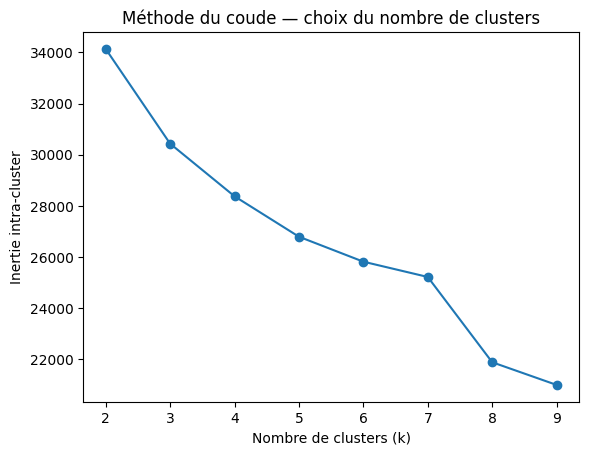

In [25]:
scaler = StandardScaler()
X = scaler.fit_transform(num_df)

inertias = []
for k in range(2, 10):
    km = KMeans(n_clusters=k, n_init='auto', random_state=42)
    km.fit(X)
    inertias.append(km.inertia_)

plt.plot(range(2, 10), inertias, marker='o')
plt.title("Méthode du coude — choix du nombre de clusters")
plt.xlabel("Nombre de clusters (k)")
plt.ylabel("Inertie intra-cluster")
plt.show()


# Selecting k and Training the KMeans Model

**This section:**
- Sets `best_k` based on elbow
- Trains KMeans and writes labels to `merged_df["cluster"]`

**Checks:**
- `merged_df["cluster"].value_counts()` to inspect cluster sizes



In [ ]:
best_k = 7  
kmeans = KMeans(n_clusters=best_k, n_init='auto', random_state=42)
merged_df["cluster"] = kmeans.fit_predict(X)

merged_df["cluster"].value_counts()


cluster
1    250
3    177
0    171
2     86
6     40
5     20
4      7
Name: count, dtype: int64

# Cluster Profiling & Interpretation

**This section:**
- Aggregates numeric features by cluster (means)
- Displays a transposed preview of top features for readability

**Goal:**  
Identify defining traits per cluster (e.g., high shooting volume, defensive intensity, passing quality).



In [27]:
# Moyenne des variables numériques par cluster
cluster_profile = merged_df.groupby("cluster").mean(numeric_only=True)
display(cluster_profile.round(2).T.head(20))

# Exemple d’interprétation : tu peux observer quelles stats dominent chaque cluster


cluster,0,1,2,3,4,5,6
atta_serial,15.39,7.39,15.53,1.81,30.57,11.20,45.15
atta_assists,0.37,0.15,0.34,0.03,2.43,3.30,1.60
atta_corner_taken,0.52,0.33,0.51,0.00,5.43,11.10,2.82
atta_offsides,0.15,0.04,0.19,0.00,5.71,1.35,3.32
atta_dribbles,1.54,0.44,1.55,0.02,24.00,16.50,14.30
atta_match_played,2.10,0.58,1.57,0.09,10.86,9.20,7.88
atte_serial,228.61,252.45,153.55,77.65,6.29,99.70,52.75
atte_total_attempts,3.92,2.33,8.27,0.46,33.86,12.20,14.05
atte_on_target,0.93,0.63,3.55,0.15,17.71,3.95,5.60
atte_off_target,1.98,1.09,2.88,0.17,9.29,4.20,4.68


# PCA Visualization (2D Projection)

**This section:**
- Runs PCA on the standardized matrix to 2 components
- Adds `pca1`, `pca2` to `merged_df`
- Plots a scatter colored by `cluster`



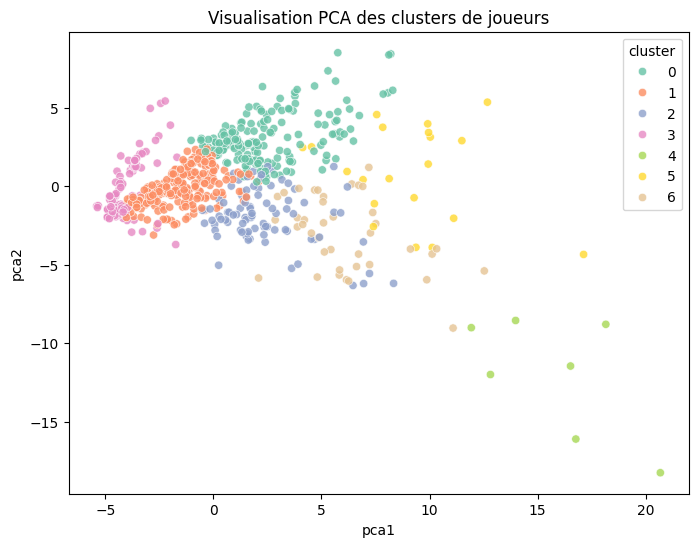

In [28]:
pca = PCA(n_components=2)
coords = pca.fit_transform(X)
merged_df["pca1"], merged_df["pca2"] = coords[:,0], coords[:,1]

plt.figure(figsize=(8,6))
sns.scatterplot(data=merged_df, x="pca1", y="pca2", hue="cluster", palette="Set2", alpha=0.8)
plt.title("Visualisation PCA des clusters de joueurs")
plt.show()


# Interpretation of PCA Visualization and Cluster Profiles

The PCA scatter plot above shows a **clear separation** of several player groups in a reduced 2D space.  
Although PCA compresses information, the clusters are visibly distinct, confirming that the KMeans segmentation captures meaningful differences in play styles and performance metrics.

### 🔹 General observations
- The first principal component (`pca1`) seems to correlate with **offensive contribution** (shots, assists, dribbles).  
- The second component (`pca2`) appears more related to **defensive activity** (tackles, clearances, recoveries).  
- Some overlap between clusters is normal, especially for **versatile players** with hybrid roles.

---

### 🧩 **Cluster interpretation**
| Cluster | Profile summary | Likely player type |
|:--:|:--|:--|
| **0** | Balanced offensive metrics (moderate shots, assists, recoveries). Decent overall stats. | *All-round midfielders / supporting forwards* |
| **1** | Low attacking and defensive actions. . | Defenders |
| **2** | High shooting frequency and on-target ratio; above-average dribbles. | *Attacking forwards / strikers* |
| **3** | Very low contribution in all categories (shots, passes, tackles). | *Rarely fielded players* |
| **4** | Extremely high attacking volume (shots, corners, offsides, dribbles). | *Elite attackers / main goal scorers* |
| **5** | Strong assist and chance creation numbers, balanced defense. | *Creative playmakers / wingers* |
| **6** | Exceptional attacking metrics (shots, dribbles, corners) combined with decent defensive actions. | Pure strikers |

---

### 💡 Insights
- Clusters **4**, **5**, and **6** represent the **most active offensive players**, but with varying roles (finisher vs. creator).  
- Clusters **0**, **2** and **1** show **balanced or specialist** tendencies depending on position.  
- Cluster **3** likely correspond to **low-minute players**, with minimal match participation.  
- The PCA plot visually confirms that elite attackers (Cluster 4) occupy the **extreme right** of the first axis.

---

### 🔎 Next analytical steps
- Cross-check clusters with **positions (FW, MF, DF)** for validation.  
- Evaluate **cluster stability** using silhouette scores.  
- Build **radar plots per cluster** to visualize strengths and weaknesses.  
- Analyze **top clubs per cluster** to see how team style influences player grouping.


# Exporting Final Results

**This section:**
- Saves the enriched dataset (clusters + PCA coords) to `champions_league_clusters.csv`


In [29]:
merged_df.to_csv("champions_league_clusters.csv", index=False)
print("✅ Fichier exporté : champions_league_clusters.csv")


✅ Fichier exporté : champions_league_clusters.csv
